- Tensor board projection 
- Visualizing loss and network on tensorboard
- Comments 

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import mpld3
mpld3.enable_notebook()

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

In [18]:
import sys
import numpy as np 
import random
import math
import tensorflow as tf
import matplotlib.pyplot as plt 

sys.path.append("../../Utils/")

In [15]:
from readWikiData import get_wikipedia_data

##### Get representation

In [19]:
def get_wiki_data():
    sentences, word2idx = get_wikipedia_data(n_files=10, n_vocab=1000, by_paragraph=True)
    training_data = []
    vocab_size = len(word2idx)
    for sentence in sentences:
        for elem1, elem2 in zip(sentence[:-1], sentence[1:]):
            training_data.append((elem1, elem2))
    training_data = list(set(training_data))
    idx2word = {v:k for k, v in word2idx.iteritems()}
    return len(word2idx), training_data, word2idx, idx2word

In [24]:
vocab_size, training_data, word2idx, idx2word = get_wiki_data()

In [8]:
len(training_data)

240044

##### Get batches

In [9]:
bucket_list = []

def getNextBatch(bi_grams_, batch_size=10000):
    global bucket_list
    docs_ids_to_select = list(set(bi_grams_) - set(bucket_list))
    
    if len(docs_ids_to_select) < batch_size:
        bucket_list = []
        docs_ids_to_select = bi_grams_
        
    # Initialize two variables 
    train_X = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    train_label = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    # Get a random set of docs 
    random_docs = random.sample(docs_ids_to_select, batch_size)
    bucket_list += random_docs
    
    index = 0 
    
    # Iterate threw all the docs 
    for item in random_docs:
        train_X[index] = item[0]
        train_label[index] = item[1]  
        index += 1
            
    return train_X, train_label

##### Let's design the graph 

In [10]:
def init_weight(Mi, Mo):
    return np.random.randn(Mi, Mo) / np.sqrt(Mi + Mo)

In [38]:
embedding_size_w = 100
vocab_size = len(word2idx)
n_neg_samples = 20
learning_rate = 0.01
epochs = 20001
batch_size=10000
mu=0.99

In [39]:
# Define placeholders for training 
train_X = tf.placeholder(tf.int32, shape=[batch_size, 1])
train_label = tf.placeholder(tf.int32, shape=[batch_size, 1])

In [40]:
# Define matrix for doc_embedding and word_embedding 
W1 = tf.Variable(init_weight(vocab_size, embedding_size_w), name="W1", dtype=tf.float32)

In [41]:
# Define weights for the output unit 
W2 = tf.Variable(init_weight(vocab_size, embedding_size_w), name="W2", dtype=tf.float32)
biases = tf.Variable(tf.zeros(vocab_size))

In [42]:
print(train_X.get_shape(), train_label.get_shape(), W1.get_shape(), W2.get_shape())

(TensorShape([Dimension(10000), Dimension(1)]), TensorShape([Dimension(10000), Dimension(1)]), TensorShape([Dimension(1001), Dimension(100)]), TensorShape([Dimension(1001), Dimension(100)]))


In [43]:
embed = tf.nn.embedding_lookup(W1, train_X[:, 0])

In [44]:
print(embed.get_shape())

(10000, 100)


In [45]:
loss = tf.nn.sampled_softmax_loss(weights=W2, \
                                  biases=biases, \
                                  labels=train_label, \
                                  inputs=embed, \
                                  num_sampled=n_neg_samples, \
                                  num_classes=vocab_size)

In [46]:
loss = tf.reduce_mean(loss)

In [47]:
#optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=mu).minimize(loss)
#optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss)


global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.01
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           1000, 0.96, staircase=True)
# Passing global_step to minimize() will increment it at each step.
optimizer = (
    tf.train.MomentumOptimizer(learning_rate, momentum=mu).minimize(loss, global_step=global_step)
)


In [48]:
saver = tf.train.Saver()

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    average_loss = 0
    
    for step in range(epochs):
        epoch_error = 0.0
        temp_X , temp_labels = getNextBatch(bi_grams_=training_data)
        feed_dict = {train_X : temp_X, train_label : temp_labels}
        
        op, l = sess.run([optimizer, loss], 
                                    feed_dict=feed_dict)
        
        epoch_error += l
                
        if step % 1000 == 0:
            print "Error at epoch : ", step, " = ", epoch_error
            
    save_path = saver.save(sess, "../models/model_bi_gram_model.ckpt")
    print("Model saved in file: %s" % save_path)

Error at epoch :  0  =  3.13913917542
Error at epoch :  1000  =  2.52231884003
Error at epoch :  2000  =  2.4065952301
Error at epoch :  3000  =  2.563570261
Error at epoch :  4000  =  2.83775997162
Error at epoch :  5000  =  2.63932085037
Error at epoch :  6000  =  2.70888900757
Error at epoch :  7000  =  2.57121610641
Error at epoch :  8000  =  2.84471511841
Error at epoch :  9000  =  2.95693206787
Error at epoch :  10000  =  2.82772135735
Error at epoch :  11000  =  2.17025613785
Error at epoch :  12000  =  2.70418167114
Error at epoch :  13000  =  2.67715883255
Error at epoch :  14000  =  2.43195223808
Error at epoch :  15000  =  2.38606905937
Error at epoch :  16000  =  2.51932549477
Error at epoch :  17000  =  2.8523375988
Error at epoch :  18000  =  2.44081091881
Error at epoch :  19000  =  2.20693302155
Error at epoch :  20000  =  2.57602071762
Model saved in file: ../models/model_bi_gram_model.ckpt


##### Embeddings 

In [49]:
W1_embedding = None
W2_embedding = None 

with tf.Session() as sess:
    saver = tf.train.Saver()
    # Restore variables from disk.
    saver.restore(sess, "../models/model_bi_gram_model.ckpt")
    print("Model restored.")
    
    # Normalize word2vec 
    W1_embedding = W1.eval()
    
    # Normalize word2vec 
    W2_embedding = W2.eval()

Model restored.


In [50]:
W1_embedding.shape

(1001, 100)

In [51]:
W2_embedding.shape

(1001, 100)

In [52]:
word2vec = np.mean([W1_embedding, W2_embedding], axis=0)

In [53]:
word2vec.shape

(1001, 100)

##### Projection of embeddings using t-SNE 

In [54]:
idx2word = {v:k for k, v in word2idx.items()}

In [55]:
from sklearn.manifold import TSNE
model = TSNE()
Z = model.fit_transform(word2vec) 

bad string: –


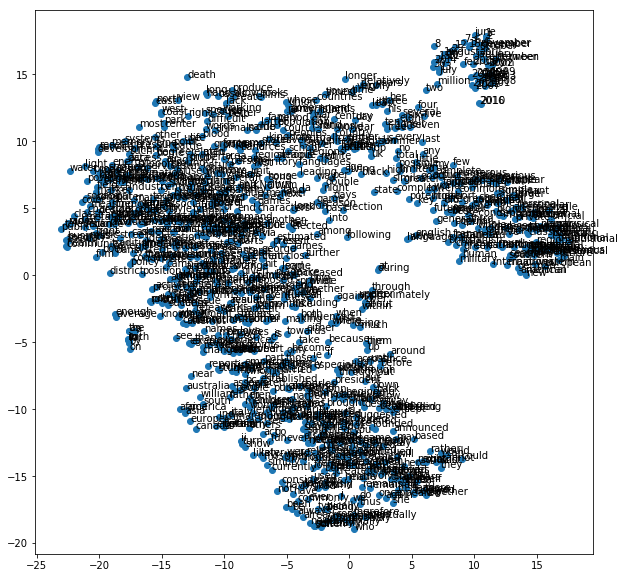

In [56]:
plt.scatter(Z[:,0], Z[:,1])
for i in xrange(len(idx2word)):
    try:
        plt.annotate(s=idx2word[i].encode("utf8"), xy=(Z[i,0], Z[i,1]))
    except:
        print "bad string:", idx2word[i]
plt.show()

In [57]:
def find_analogies(w1, w2, w3, We, word2idx):
    king = We[word2idx[w1]]
    man = We[word2idx[w2]]
    woman = We[word2idx[w3]]
    v0 = king - man + woman

    def dist1(a, b):
        return np.linalg.norm(a - b)
    def dist2(a, b):
        return 1 - a.dot(b) / (np.linalg.norm(a) * np.linalg.norm(b))

    for dist, name in [(dist1, 'Euclidean'), (dist2, 'cosine')]:
        min_dist = float('inf')
        best_word = ''
        for word, idx in word2idx.iteritems():
            if word not in (w1, w2, w3):
                v1 = We[idx]
                d = dist(v0, v1)
                if d < min_dist:
                    min_dist = d
                    best_word = word
        print "closest match by", name, "distance:", best_word
        print w1, "-", w2, "=", best_word, "-", w3

In [58]:
we = word2vec
w2i = word2idx

In [59]:
find_analogies(w1='1', w2='3', w3='2',We=we, word2idx=w2i)
find_analogies(w1='england', w2='london', w3='france',We=we, word2idx=w2i)
find_analogies(w1='english', w2='french', w3='german',We=we, word2idx=w2i)
find_analogies(w1='east', w2='west', w3='north',We=we, word2idx=w2i)
find_analogies(w1='lower', w2='higher', w3='low',We=we, word2idx=w2i)
find_analogies(w1='two', w2='three', w3='four',We=we, word2idx=w2i)
find_analogies(w1='december', w2='november', w3='january',We=we, word2idx=w2i)
find_analogies(w1='december', w2='november', w3='july',We=we, word2idx=w2i)
find_analogies(w1='two', w2='three', w3='five',We=we, word2idx=w2i)
find_analogies(w1='eastern', w2='western', w3='northern',We=we, word2idx=w2i)

closest match by Euclidean distance: ad
1 - 3 = ad - 2
closest match by cosine distance: around
1 - 3 = around - 2
closest match by Euclidean distance: soon
england - london = soon - france
closest match by cosine distance: soon
england - london = soon - france
closest match by Euclidean distance: medical
english - french = medical - german
closest match by cosine distance: medical
english - french = medical - german
closest match by Euclidean distance: george
east - west = george - north
closest match by cosine distance: george
east - west = george - north
closest match by Euclidean distance: active
lower - higher = active - low
closest match by cosine distance: additional
lower - higher = additional - low
closest match by Euclidean distance: days
two - three = days - four
closest match by cosine distance: 30
two - three = 30 - four
closest match by Euclidean distance: june
december - november = june - january
closest match by cosine distance: july
december - november = july - january